<a href="https://colab.research.google.com/github/muhammadaarif-9/codemix/blob/main/simAlign_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
#!pip install simalign
#!pip install sacremoses
from simalign import SentenceAligner
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [34]:
# all_annotated
data = []
with open("all_annotated.txt") as fp:
  data = fp.read().split("\n")

In [35]:
# baseline_microsoft
baseline_data = []
with open("Microsoft_without_GA_858.txt") as fp:
  baseline_data = fp.read().split("\n")

In [36]:
store_data = []
fp_store_data = open("recall.txt","w")
def store(txt):
  fp_store_data.write(txt+"\n")
models_count = 0
models = ["l3cube-pune/hing-mbert","bert-base-multilingual-cased","bert-base-multilingual-uncased","xlm-mlm-100-1280","roberta-base","xlm-roberta-base","xlm-roberta-large","bert-base-uncased"]

In [37]:
import os
import logging
from typing import Dict, List, Tuple, Union

import numpy as np
from scipy.stats import entropy
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
try:
	import networkx as nx
	from networkx.algorithms.bipartite.matrix import from_biadjacency_matrix
except ImportError:
	nx = None
import torch
from transformers import BertModel, BertTokenizer, XLMModel, XLMTokenizer, RobertaModel, RobertaTokenizer, XLMRobertaModel, XLMRobertaTokenizer, AutoConfig, AutoModel, AutoTokenizer, AutoModelForMaskedLM

from simalign.utils import get_logger

LOG = get_logger(__name__)


class EmbeddingLoader(object):
	def __init__(self, model: str="xlm-roberta-base", device=torch.device('cpu'), layer: int=8):
		TR_Models = {
			'bert-base-uncased': (BertModel, BertTokenizer),
			'bert-base-multilingual-cased': (BertModel, BertTokenizer),
			'bert-base-multilingual-uncased': (BertModel, BertTokenizer),
			'xlm-mlm-100-1280': (XLMModel, XLMTokenizer),
			'roberta-base': (RobertaModel, RobertaTokenizer),
			'xlm-roberta-base': (XLMRobertaModel, XLMRobertaTokenizer),
			'xlm-roberta-large': (XLMRobertaModel, XLMRobertaTokenizer),
		}

		self.model = model
		self.device = device
		self.layer = layer
		self.emb_model = None
		self.tokenizer = None

		if False:
			model_class, tokenizer_class = TR_Models[model]
			self.emb_model = AutoModelForMaskedLM.from_pretrained(model, output_hidden_states=True)
			self.emb_model.eval()
			self.emb_model.to(self.device)
			self.tokenizer = AutoTokenizer.from_pretrained(model,add_prefix_space=True)
		else:
			# try to load model with auto-classes
			config = AutoConfig.from_pretrained(model, output_hidden_states=True)
			self.emb_model = AutoModel.from_pretrained(model, config=config)
			self.emb_model.eval()
			self.emb_model.to(self.device)
			self.tokenizer = AutoTokenizer.from_pretrained(model,add_prefix_space=True) # add_prefix_space=True for roberta and gpt2
		LOG.info("Initialized the EmbeddingLoader with model: {}".format(self.model))

	def get_embed_list(self, sent_batch: List[List[str]]) -> torch.Tensor:
		if self.emb_model is not None:
			with torch.no_grad():
				if not isinstance(sent_batch[0], str):
					inputs = self.tokenizer(sent_batch, is_split_into_words=True, padding=True, truncation=True, return_tensors="pt")
				else:
					inputs = self.tokenizer(sent_batch, is_split_into_words=False, padding=True, truncation=True, return_tensors="pt")
				hidden = self.emb_model(**inputs.to(self.device))["hidden_states"]
				if self.layer >= len(hidden):
					raise ValueError(f"Specified to take embeddings from layer {self.layer}, but model has only {len(hidden)} layers.")
				outputs = hidden[self.layer]
				return outputs[:, 1:-1, :]
		else:
			return None


class SentenceAligner(object):
	def __init__(self, model: str = "xlm-roberta-base", token_type: str = "bpe", distortion: float = 0.0, matching_methods: str = "mai", device: str = "cpu", layer: int = 8):
		model_names = {
			"bert": "bert-base-multilingual-cased",
			"xlmr": "xlm-roberta-base"
			}
		all_matching_methods = {"a": "inter", "m": "mwmf", "i": "itermax", "f": "fwd", "r": "rev"}

		self.model = model
		if model in model_names:
			self.model = model_names[model]
		self.token_type = token_type
		self.distortion = distortion
		self.matching_methods = [all_matching_methods[m] for m in matching_methods]
		self.device = torch.device(device)

		self.embed_loader = EmbeddingLoader(model=self.model, device=self.device, layer=layer)

	@staticmethod
	def get_max_weight_match(sim: np.ndarray) -> np.ndarray:
		if nx is None:
			raise ValueError("networkx must be installed to use match algorithm.")
		def permute(edge):
			if edge[0] < sim.shape[0]:
				return edge[0], edge[1] - sim.shape[0]
			else:
				return edge[1], edge[0] - sim.shape[0]
		G = from_biadjacency_matrix(csr_matrix(sim))
		matching = nx.max_weight_matching(G, maxcardinality=True)
		matching = [permute(x) for x in matching]
		matching = sorted(matching, key=lambda x: x[0])
		res_matrix = np.zeros_like(sim)
		for edge in matching:
			res_matrix[edge[0], edge[1]] = 1
		return res_matrix

	@staticmethod
	def get_similarity(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
		return (cosine_similarity(X, Y) + 1.0) / 2.0

	@staticmethod
	def average_embeds_over_words(bpe_vectors: np.ndarray, word_tokens_pair: List[List[str]]) -> List[np.array]:
		w2b_map = []
		cnt = 0
		w2b_map.append([])
		for wlist in word_tokens_pair[0]:
			w2b_map[0].append([])
			for x in wlist:
				w2b_map[0][-1].append(cnt)
				cnt += 1
		cnt = 0
		w2b_map.append([])
		for wlist in word_tokens_pair[1]:
			w2b_map[1].append([])
			for x in wlist:
				w2b_map[1][-1].append(cnt)
				cnt += 1

		new_vectors = []
		for l_id in range(2):
			w_vector = []
			for word_set in w2b_map[l_id]:
				w_vector.append(bpe_vectors[l_id][word_set].mean(0))
			new_vectors.append(np.array(w_vector))
		return new_vectors

	@staticmethod
	def get_alignment_matrix(sim_matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
		m, n = sim_matrix.shape
		forward = np.eye(n)[sim_matrix.argmax(axis=1)]  # m x n
		backward = np.eye(m)[sim_matrix.argmax(axis=0)]  # n x m
		return forward, backward.transpose()

	@staticmethod
	def apply_distortion(sim_matrix: np.ndarray, ratio: float = 0.5) -> np.ndarray:
		shape = sim_matrix.shape
		if (shape[0] < 2 or shape[1] < 2) or ratio == 0.0:
			return sim_matrix

		pos_x = np.array([[y / float(shape[1] - 1) for y in range(shape[1])] for x in range(shape[0])])
		pos_y = np.array([[x / float(shape[0] - 1) for x in range(shape[0])] for y in range(shape[1])])
		distortion_mask = 1.0 - ((pos_x - np.transpose(pos_y)) ** 2) * ratio

		return np.multiply(sim_matrix, distortion_mask)

	@staticmethod
	def iter_max(sim_matrix: np.ndarray, max_count: int=2) -> np.ndarray:
		alpha_ratio = 0.9
		m, n = sim_matrix.shape
		forward = np.eye(n)[sim_matrix.argmax(axis=1)]  # m x n
		backward = np.eye(m)[sim_matrix.argmax(axis=0)]  # n x m
		inter = forward * backward.transpose()

		if min(m, n) <= 2:
			return inter

		new_inter = np.zeros((m, n))
		count = 1
		while count < max_count:
			mask_x = 1.0 - np.tile(inter.sum(1)[:, np.newaxis], (1, n)).clip(0.0, 1.0)
			mask_y = 1.0 - np.tile(inter.sum(0)[np.newaxis, :], (m, 1)).clip(0.0, 1.0)
			mask = ((alpha_ratio * mask_x) + (alpha_ratio * mask_y)).clip(0.0, 1.0)
			mask_zeros = 1.0 - ((1.0 - mask_x) * (1.0 - mask_y))
			if mask_x.sum() < 1.0 or mask_y.sum() < 1.0:
				mask *= 0.0
				mask_zeros *= 0.0

			new_sim = sim_matrix * mask
			fwd = np.eye(n)[new_sim.argmax(axis=1)] * mask_zeros
			bac = np.eye(m)[new_sim.argmax(axis=0)].transpose() * mask_zeros
			new_inter = fwd * bac

			if np.array_equal(inter + new_inter, inter):
				break
			inter = inter + new_inter
			count += 1
		return inter

	def get_word_aligns(self, src_sent: Union[str, List[str]], trg_sent: Union[str, List[str]]) -> Dict[str, List]:
		if isinstance(src_sent, str):
			src_sent = src_sent.split()
		if isinstance(trg_sent, str):
			trg_sent = trg_sent.split()
		l1_tokens = [self.embed_loader.tokenizer.tokenize(word) for word in src_sent]
		l2_tokens = [self.embed_loader.tokenizer.tokenize(word) for word in trg_sent]
		bpe_lists = [[bpe for w in sent for bpe in w] for sent in [l1_tokens, l2_tokens]]

		if self.token_type == "bpe":
			l1_b2w_map = []
			for i, wlist in enumerate(l1_tokens):
				l1_b2w_map += [i for x in wlist]
			l2_b2w_map = []
			for i, wlist in enumerate(l2_tokens):
				l2_b2w_map += [i for x in wlist]

		vectors = self.embed_loader.get_embed_list([src_sent, trg_sent]).cpu().detach().numpy()
		vectors = [vectors[i, :len(bpe_lists[i])] for i in [0, 1]]

		if self.token_type == "word":
			vectors = self.average_embeds_over_words(vectors, [l1_tokens, l2_tokens])

		all_mats = {}
		sim = self.get_similarity(vectors[0], vectors[1])
		sim = self.apply_distortion(sim, self.distortion)

		all_mats["fwd"], all_mats["rev"] = self.get_alignment_matrix(sim)
		all_mats["inter"] = all_mats["fwd"] * all_mats["rev"]
		if "mwmf" in self.matching_methods:
			all_mats["mwmf"] = self.get_max_weight_match(sim)
		if "itermax" in self.matching_methods:
			all_mats["itermax"] = self.iter_max(sim)

		aligns = {x: set() for x in self.matching_methods}
		for i in range(len(vectors[0])):
			for j in range(len(vectors[1])):
				for ext in self.matching_methods:
					if all_mats[ext][i, j] > 0:
						if self.token_type == "bpe":
							aligns[ext].add((l1_b2w_map[i], l2_b2w_map[j]))
						else:
							aligns[ext].add((i, j))
		for ext in aligns:
			aligns[ext] = sorted(aligns[ext])
		return aligns

In [38]:
#simalign_model_name = models[models_count % len(models)]
#models_count += 1

In [39]:
#store("using "+ simalign_model_name)

In [40]:
#print(simalign_model_name)

In [41]:
# making an instance of our model.
# You can specify the embedding model and all alignment settings in the constructor.
#myaligner = SentenceAligner(model="xlm-roberta-base", token_type="bpe", matching_methods="maifr") 
#myaligner = SentenceAligner(model=simalign_model_name, token_type="bpe", matching_methods="maifr") 
#myaligner = SentenceAligner(model="xlm-mlm-100-1280", token_type="bpe", matching_methods="maifr") 
#myaligner = SentenceAligner(model="roberta-base", token_type="bpe", matching_methods="mai") 
#myaligner = SentenceAligner(model="xlm-roberta-large", token_type="bpe", matching_methods="mai")
#myaligner = SentenceAligner(model="bert", token_type="bpe", matching_methods="mai") 

In [42]:
# #baseline
# sent_num = 23
# baseline_sent_num = 11
# eng_sent = data[sent_num]
# hing_sent = baseline_data[baseline_sent_num ]
# print("sentence")
# print(eng_sent)
# print(hing_sent)
# eng_sent = word_tokenize(eng_sent)
# hing_sent = word_tokenize(hing_sent)
# print("After tokenize")
# print(eng_sent)
# print(hing_sent)
# print("after stopword removal")
# eng_sent =  [w for w in eng_sent if not w.lower() in stop_words]
# hing_sent = [w for w in hing_sent if not w.lower() in stop_words]
# print(eng_sent)
# print(hing_sent)
# # enumerate 
# print(list(enumerate(eng_sent)))
# print(list(enumerate(hing_sent)))
# groundtruth = [
#   [(0,0),(1,1),(2,2)],
#   [(0,0),(1,1),(2,2)],
#   [(0,0),(1,1),(2,2)],
#   [(0,1),(1,2),(2,3)],
#   [(0,6),(1,4),(2,1)], 
# ]

In [43]:
# sent_num = 35
# num_hing_sent = 8
# eng_sent = data[sent_num]
# hing_sent = data[36]
# #hing_sent = baseline_data[11]
# print("sentence")
# print(eng_sent)
# print(hing_sent)
# eng_sent = word_tokenize(eng_sent)
# hing_sent = word_tokenize(hing_sent)
# print("After tokenize")
# print(eng_sent)
# print(hing_sent)
# #print("after stopword removal")
# #eng_sent =  [w for w in eng_sent if not w.lower() in stop_words]
# #hing_sent = [w for w in hing_sent if not w.lower() in stop_words]
# #print(eng_sent)
# #print(hing_sent)
# # enumerate 
# print(list(enumerate(eng_sent)))
# print(list(enumerate(hing_sent)))
# groundtruth = [
#     [(1,5),(3,3),(5,1)]
# ]

In [44]:
# # test
# models_count+=1
# simalign_model_name = models[models_count % len(models)]
# myaligner = SentenceAligner(model=simalign_model_name, token_type="bpe", matching_methods="maifr")

In [45]:
# # test
# alignments_simalign = myaligner.get_word_aligns(eng_sent, hing_sent)
# count = 0
# for matching_method in alignments_simalign:
#   print(matching_method,alignments_simalign[matching_method])
#   if len(groundtruth[0][0]) == 0:
#     print(groundtruth[1]) 
#   for item in alignments_simalign[matching_method]:
#     if item in groundtruth[0]:
#       count+=1
#   print("accuracy: ",count / len(groundtruth[0]))
#   count = 0

In [ ]:
rows = []
sent_metrics = []
skip_track = 0
for s in range(len(models)): # 
  simalign_model_name = models[models_count % len(models)]
  models_count += 1
  store("using "+ simalign_model_name)
  myaligner = SentenceAligner(model=simalign_model_name, token_type="bpe", matching_methods="maifr")
  metric_score_per_sent_pair = []
  for k in range(6,7):
    if k == 0:
      sent_num = 23
      num_hing_sent = 8
      store("############## [hinglish from human_annotated] ##############")
      store("sentence_pair 3")
      groundtruth = [
        [(5,5),(6,6)],
        [()],  # no mapping
        [(6,8)],
        [(5,5)],
        [(6,6)],
        [()], # no mapping
        [(5,4),(6,5)],
        [(5,7)]
      ]
    elif k == 1:
      sent_num = 35
      num_hing_sent = 8
      store("sentence_pair 4")
      groundtruth = [
        [(1,5)],
        [()],  # no mapping
        [(3,2)],
        [(3,2)],
        [(3,3)],
        [()], # no mapping
        [()],
        [(1,6)]
      ]
    elif k == 2:
      sent_num = 56
      num_hing_sent = 7
      store("sentence_pair 6")
      groundtruth = [
        [(0,5)],
        [(4,3)],  # no mapping
        [(4,0)],
        [(4,0)],
        [(4,3)],
        [()], # no mapping
        [(0,4),(4,0)],
      ]
    elif k == 3:
      sent_num = 77
      num_hing_sent = 6
      store("sentence_pair 8")
      groundtruth = [
       [(4,1)],
       [(5,2)],  # no mapping
       [(4,1)],
       [(5,2)],
       [(4,4),(5,5)],
       [()], # no mapping
      ]
    elif k == 4:
      sent_num = 23
      num_hing_sent = 2
      store("############## [hinglish from Baseline] ##############")
      store("sentence_pair 3")
      groundtruth = [
        [()],
        [(6,7)]
      ]
      hing_sent_num = 3344
    elif k == 5:
      sent_num = 35
      num_hing_sent = 5
      store("sentence_pair 4")
      groundtruth = [
        [()],
        [(3,3),(5,6)],
        [()],
        [(3,3)],
        [(1,6),(3,4)]
      ]
      hing_sent_num = 6
    elif k == 6:
      sent_num = 23
      num_hing_sent = 1
      store("############## [hindi from human annotation] ##############")
      store("sentence_pair 3")
      groundtruth = [
        [(0,2),(3,0),(5,7),(6,8)]
      ]
    elif k == 7:
      sent_num = 35
      num_hing_sent = 1
      store("sentence_pair 4")
      groundtruth = [
        [(1,5),(3,3),(5,1)]
      ]
    eng_sent_num = sent_num
    eng_sent = word_tokenize(data[sent_num])
    sent_num += 2
    if k >= 4 and k < 6: sent_num = hing_sent_num
    if k >= 6: sent_num = sent_num - 1 
  
    metric_val_per_hing = []
    for i in range(num_hing_sent):
      skip_track = 0
      if len(groundtruth[i][0]) == 0:
        store("No non-trivial mappings ---> Skipping this sentence")
        skip_track = 1
        continue
      store("eng-hing sentence pair - hing sentence_num "+str(i+1))
      store("[eng] "+ data[eng_sent_num])
      if k >= 4 and k < 6:
        store("[hing] "+baseline_data[sent_num])
      else:
        store("[hing] "+data[sent_num])
      #tokenize
      store("[nltk_tokenize]")
      store("[eng] "+ str(eng_sent))
      if k >= 4 and k < 6:
        hing_sent = word_tokenize(baseline_data[sent_num])
        # print("hinglish",k)
        # print("num_hing_sent",num_hing_sent)
        # print("count of hing",i+1)
      else:
        hing_sent = word_tokenize(data[sent_num])
      store("[hing] "+ str(hing_sent))
      #eng_sent = [w for w in eng_sent if not w.lower() in stop_words]
      #hing_sent = [w for w in hing_sent if not w.lower() in stop_words]
      #store("[after stopwords removal]")
      #store("[eng]"+str(eng_sent))
      #store("[hing]"+str(hing_sent))
      store("[enumerate tokens]")
      store("[eng]"+str(list(enumerate(eng_sent))))
      store("[hing]"+str(list(enumerate(hing_sent))))
      store("[groundtruth]")
      store(str(groundtruth[i]))
      alignments_simalign = myaligner.get_word_aligns(eng_sent, hing_sent)
      metric_val_per_method = []
      count = 0
      for matching_method in alignments_simalign:
        store("method: "+matching_method)
        store("sent_num: "+ str(sent_num))
        align_map = []
        for item in alignments_simalign[matching_method]:
          if item in groundtruth[i]:
            temp = str(eng_sent[item[0]]) + "----->" + str(hing_sent[item[1]])
            align_map.append(temp)
            count+=1
        store("mappings:"+str(align_map))
        store("recall: "+str(count / len(groundtruth[i])))
        metric_val_per_method.append(str(count / len(groundtruth[i])))
        count = 0
      metric_val_per_hing.append(metric_val_per_method)
      sent_num += 1
      store("\n")
    metric_score_all_hing_pair = []
    for loop_iter_row in range(len(metric_val_per_hing[0])):
      metric_score_all_hing_pair.append(0)

    for loop_iter_row in range(len(metric_val_per_hing)):
      for loop_iter_col in range(len(metric_val_per_hing[loop_iter_row])):
        metric_score_all_hing_pair[loop_iter_col] = float(metric_score_all_hing_pair[loop_iter_col]) +  float(metric_val_per_hing[loop_iter_row][loop_iter_col])
    
    for loop_iter_row in range(len(metric_val_per_hing[0])):
      metric_score_all_hing_pair[loop_iter_row] = float(metric_score_all_hing_pair[loop_iter_row]) / float(len(metric_val_per_hing))
    
    metric_score_per_sent_pair.append(metric_score_all_hing_pair)
  
  temp_list = []
  for loop_iter_row in range(len(metric_score_per_sent_pair[0])):
    temp_list.append(0)
  for loop_iter_row in range(len(metric_score_per_sent_pair)):
    for loop_iter_col in range(len(metric_score_per_sent_pair[loop_iter_row])):
      temp_list[loop_iter_col] = float(temp_list[loop_iter_col]) +  float(metric_score_per_sent_pair[loop_iter_row][loop_iter_col])
  for loop_iter_row in range(len(metric_score_per_sent_pair[0])):
    temp_list[loop_iter_row] = float(temp_list[loop_iter_row]) / float(len(metric_score_per_sent_pair))
  temp_list.insert(0,simalign_model_name)
  sent_metrics.append(temp_list)  
fp_store_data.close()

In [47]:
first_row = ["Model Name","mwmf","inter","itermax","fwd","rev"]
table = [first_row,sent_metrics[0],
         sent_metrics[1],
         sent_metrics[2],
         sent_metrics[3],
         sent_metrics[4],
         sent_metrics[5],
         sent_metrics[6],
         sent_metrics[7]]

In [48]:
#!pip install tabulate
from tabulate import tabulate
print("####################### Recall metrics for 4-Sentence Pair [eng-hing]####################")
print(tabulate(table,headers='firstrow',tablefmt='grid',stralign='center',showindex="always"))

####################### Recall metrics for 4-Sentence Pair [eng-hing]####################
+----+--------------------------------+--------+---------+-----------+-------+-------+
|    |           Model Name           |   mwmf |   inter |   itermax |   fwd |   rev |
+====+================================+========+=========+===========+=======+=======+
|  0 |     l3cube-pune/hing-mbert     |   0.5  |    0    |      0    |  0.25 |  0.25 |
+----+--------------------------------+--------+---------+-----------+-------+-------+
|  1 |  bert-base-multilingual-cased  |   0.75 |    0.5  |      0.5  |  0.5  |  0.5  |
+----+--------------------------------+--------+---------+-----------+-------+-------+
|  2 | bert-base-multilingual-uncased |   0.5  |    0    |      0.25 |  0.25 |  0.5  |
+----+--------------------------------+--------+---------+-----------+-------+-------+
|  3 |        xlm-mlm-100-1280        |   0.25 |    0.25 |      0.25 |  0.5  |  0.5  |
+----+--------------------------------+-

In [493]:
# from IPython.display import display
# import pandas as pd
# dataframe = pd.DataFrame(all_stats)
# # displaying the DataFrame
# display(dataframe)

In [211]:
# previous one
# for s in range(len(models)): # 
#   simalign_model_name = models[models_count % len(models)]
#   models_count += 1
#   store("using "+ simalign_model_name)
#   print(simalign_model_name)
#   myaligner = SentenceAligner(model=simalign_model_name, token_type="bpe", matching_methods="maifr")
#   for k in range(1):
#     if k == 0:
#       sent_num = 23
#       num_hing_sent = 8
#       store("############## [hinglish from human_annotated] ##############")
#       store("sentence_pair 3")
#       groundtruth = [
#         [(5,5),(6,6)],
#         [()],  # no mapping
#         [(6,8)],
#         [(5,5)],
#         [(6,6)],
#         [()], # no mapping
#         [(5,4),(6,5)],
#         [(5,7)]
#       ]
#     elif k == 1:
#       sent_num = 35
#       num_hing_sent = 8
#       store("sentence_pair 4")
#       groundtruth = [
#         [(0,4),(1,1),(2,2),(3,6)],
#         [(0,3),(1,1),(2,2),(3,5)],
#         [(0,0),(1,1),(2,2),(3,3)],
#         [(0,5),(1,2),(2,0),(3,7)],
#         [(0,5),(1,3),(2,1),(3,7)],
#         [(0,0),(1,3),(2,1),(3,4)],
#         [(0,0),(1,1),(2,2),(3,3)],
#         [(0,4),(1,2),(2,0),(3,5)]
#       ]
#     elif k == 2:
#       sent_num = 56
#       num_hing_sent = 7
#       store("sentence_pair 6")
#       groundtruth = [
#         [(0,5),(1,2),(2,0),(3,1)],
#         [(0,0),(1,1),(3,2)],
#         [(0,4),(1,1),(3,0)],
#         [(0,4),(1,2),(3,0)],
#         [(0,0),(1,1),(3,2)],
#         [(0,4),(1,2),(2,0),(3,1),(4,5)],
#         [(0,3),(1,1),(3,0),(4,4)]
#       ]
#     elif k == 3:
#       sent_num = 77
#       num_hing_sent = 6
#       store("sentence_pair 8")
#       groundtruth = [
#         [(0,3),(1,4),(2,1),(3,2)],
#         [(0,2),(1,3),(2,0),(3,1)],
#         [(0,2),(1,3),(2,0),(3,1)],
#         [(0,3),(1,4),(2,1),(3,2)],
#         [(0,0),(1,1),(2,2),(3,3)],
#         [(0,0),(1,1),(2,3),(3,4)],
#       ]
#     elif k == 4:
#       sent_num = 23
#       num_hing_sent = 2
#       store("############## [hinglish from Baseline] ##############")
#       store("sentence_pair 3")
#       groundtruth = [
#         [(0,2),(1,0),(2,5),(3,6),(4,7)],
#         [(0,2),(1,0),(2,5),(3,6),(4,7)]
#       ]
#       hing_sent_num = 3344
#     elif k == 5:
#       sent_num = 35
#       num_hing_sent = 5
#       store("sentence_pair 4")
#       groundtruth = [
#         [(0,0),(1,1),(2,2)],
#         [(0,0),(1,1),(2,2)],
#         [(0,0),(1,1),(2,2)],
#         [(0,1),(1,2),(2,3)],
#         [(0,6),(1,4),(2,1)] 
#       ]
#       hing_sent_num = 6
#     elif k == 6:
#       sent_num = 23
#       num_hing_sent = 1
#       store("############## [hindi from human annotation] ##############")
#       store("sentence_pair 3")
#       groundtruth = [
#         [(0,2),(1,0),(2,6),(3,7),(4,8),(5,10)]
#       ]
#     elif k == 7:
#       sent_num = 35
#       num_hing_sent = 1
#       store("sentence_pair 4")
#       groundtruth = [
#         [(0,5),(1,3),(2,1)]
#       ]
#     eng_sent_num = sent_num
#     eng_sent = word_tokenize(data[sent_num])
#     sent_num += 2
#     if k >= 4 and k < 6: sent_num = hing_sent_num
#     if k >= 6: sent_num = sent_num - 1 
#     for i in range(num_hing_sent):
#       store("eng-hing sentence pair - hing sentence_num "+str(i+1))
#       store("[eng] "+ data[eng_sent_num])
#       if k >= 4 and k < 6:
#         store("[hing] "+baseline_data[sent_num])
#       else:
#         store("[hing] "+data[sent_num])
#       #tokenize
#       store("[nltk_tokenize]")
#       store("[eng] "+ str(eng_sent))
#       if k >= 4 and k < 6:
#         hing_sent = word_tokenize(baseline_data[sent_num])
#         # print("hinglish",k)
#         # print("num_hing_sent",num_hing_sent)
#         # print("count of hing",i+1)
#       else:
#         hing_sent = word_tokenize(data[sent_num])
#       store("[hing] "+ str(hing_sent))
#       eng_sent = [w for w in eng_sent if not w.lower() in stop_words]
#       hing_sent = [w for w in hing_sent if not w.lower() in stop_words]
#       store("[after stopwords removal]")
#       store("[eng]"+str(eng_sent))
#       store("[hing]"+str(hing_sent))
#       store("[enumerate tokens]")
#       store("[eng]"+str(list(enumerate(eng_sent))))
#       store("[hing]"+str(list(enumerate(hing_sent))))
#       store("[groundtruth]")
#       store(str(groundtruth[i]))
#       alignments_simalign = myaligner.get_word_aligns(eng_sent, hing_sent)
#       store_alignments = {}
#       for matching_method in alignments_simalign:
#         store_alignments[matching_method] = alignments_simalign[matching_method]
#       store("[simalign output]")
#       store(str(store_alignments))
#       methods_of_simalign = ["mwmf","inter","itermax","fwd","rev"]
#       for j in range(len(methods_of_simalign)):
#         simalign_method = methods_of_simalign[j]
#         count = 0
#         simalign_map = []
#         for item in alignments_simalign[simalign_method]:
#           temp = str(eng_sent[item[0]]) + "----->" + str(hing_sent[item[1]])
#           simalign_map.append(temp)
#           if item in groundtruth[i]:
#             count += 1
#         # accuracy 
#         accuracy = round(count/len(alignments_simalign[simalign_method]),2)
#         store("method: "+simalign_method)
#         store(str(simalign_map))
#         store("accuracy: "+str(accuracy))
#       sent_num += 1
#       store("\n")
# fp_store_data.close()

In [ ]:
# for k in range(4):
#   if k == 0:
#     sent_num = 23
#     num_hing_sent = 8
#     store("sentence_pair 3")
#     groundtruth = [
#       [(0,0),(1,1),(2,2),(3,3),(4,4),(5,6)],
#       [(0,2),(1,0),(2,6),(3,7),(4,8),(5,9)],
#       [(0,2),(1,0),(2,6),(3,7),(4,8),(5,10)],
#       [(0,0),(1,1),(2,2),(3,3),(4,4),(5,6)],
#       [(0,0),(1,1),(2,2),(3,3),(4,4),(5,6)],
#       [(0,2),(1,0),(2,6),(3,7),(4,8),(5,9)],
#       [(0,0),(1,1),(2,2),(3,3),(4,4),(5,6)],
#       [(0,2),(1,0),(2,6),(3,7),(4,8),(5,10)]
#     ]
#   elif k == 1:
#     sent_num = 35
#     num_hing_sent = 8
#     store("sentence_pair 4")
#     groundtruth = [
#       [(0,4),(1,1),(2,2),(3,6)],
#       [(0,3),(1,1),(2,2),(3,5)],
#       [(0,0),(1,1),(2,2),(3,3)],
#       [(0,5),(1,2),(2,0),(3,7)],
#       [(0,5),(1,3),(2,1),(3,7)],
#       [(0,0),(1,3),(2,1),(3,4)],
#       [(0,0),(1,1),(2,2),(3,3)],
#       [(0,4),(1,2),(2,0),(3,5)]
#     ]
#   elif k == 2:
#     sent_num = 56
#     num_hing_sent = 7
#     store("sentence_pair 6")
#     groundtruth = [
#       [(0,5),(1,2),(2,0),(3,1)],
#       [(0,0),(1,1),(3,2)],
#       [(0,4),(1,1),(3,0)],
#       [(0,4),(1,2),(3,0)],
#       [(0,0),(1,1),(3,2)],
#       [(0,4),(1,2),(2,0),(3,1),(4,5)],
#       [(0,3),(1,1),(3,0),(4,4)]
#     ]
#   elif k == 3:
#     sent_num = 77
#     num_hing_sent = 6
#     store("sentence_pair 8")
#     groundtruth = [
#       [(0,3),(1,4),(2,1),(3,2)],
#       [(0,2),(1,3),(2,0),(3,1)],
#       [(0,2),(1,3),(2,0),(3,1)],
#       [(0,3),(1,4),(2,1),(3,2)],
#       [(0,0),(1,1),(2,2),(3,3)],
#       [(0,0),(1,1),(2,3),(3,4)],
#     ]
#   store("[eng] "+ data[sent_num])
#   eng_sent = word_tokenize(data[sent_num])
#   sent_num += 2
#   for i in range(num_hing_sent):
#     store("[hing] "+data[sent_num])
#     #tokenize
#     store("[nltk_tokenize]")
#     store("[eng] "+ str(eng_sent))
#     hing_sent = word_tokenize(data[sent_num])
#     store("[hing] "+ str(hing_sent))
#     eng_sent = [w for w in eng_sent if not w.lower() in stop_words]
#     hing_sent = [w for w in hing_sent if not w.lower() in stop_words]
#     store("after stopwords removal")
#     store("[eng]"+str(eng_sent))
#     store("[hing]"+str(hing_sent))
#     store("enumerate tokens")
#     store("[eng]"+str(list(enumerate(eng_sent))))
#     store("[hing]"+str(list(enumerate(hing_sent))))
#     store("groundtruth")
#     store(str(groundtruth[i]))
#     alignments_simalign = myaligner.get_word_aligns(eng_sent, hing_sent)
#     store_alignments = {}
#     for matching_method in alignments_simalign:
#       store_alignments[matching_method] = alignments_simalign[matching_method]
#     store("simalign output")
#     store(str(store_alignments))
#     methods_of_simalign = ["mwmf","inter","itermax","fwd","rev"]
#     for j in range(len(methods_of_simalign)):
#       simalign_method = methods_of_simalign[j]
#       count = 0
#       simalign_map = []
#       for item in alignments_simalign[simalign_method]:
#         temp = str(eng_sent[item[0]]) + "----->" + str(hing_sent[item[1]])
#         simalign_map.append(temp)
#         if item in groundtruth[i]:
#           count += 1
#       # accuracy 
#       accuracy = round(count/len(alignments_simalign[simalign_method]),2)
#       store("method: "+simalign_method)
#       store("accuracy: "+str(accuracy))
#       store(str(simalign_map))
#     sent_num += 1
#     store("\n")

In [ ]:
# fp_store_data.close()

In [ ]:
# if sent_pair_count == 0:
#   sent_num = 23
#   num_hing_sent = 8
#   store("sentence_pair 3")
#   groundtruth = [
#    [(0,0),(1,1),(2,2),(3,3),(4,4),(5,6)],
#    [(0,2),(1,0),(2,6),(3,7),(4,8),(5,9)],
#    [(0,2),(1,0),(2,6),(3,7),(4,8),(5,10)],
#    [(0,0),(1,1),(2,2),(3,3),(4,4),(5,6)],
#    [(0,0),(1,1),(2,2),(3,3),(4,4),(5,6)],
#    [(0,2),(1,0),(2,6),(3,7),(4,8),(5,9)],
#    [(0,0),(1,1),(2,2),(3,3),(4,4),(5,6)],
#    [(0,2),(1,0),(2,6),(3,7),(4,8),(5,10)]
#   ]
# elif sent_pair_count == 1:
#   sent_num = 35
#   num_hing_sent = 8
#   store("sentence_pair 4")
#   groundtruth = [
#     [(0,4),(1,1),(2,2),(3,6)],
#     [(0,3),(1,1),(2,2),(3,5)],
#     [(0,0),(1,1),(2,2),(3,3)],
#     [(0,5),(1,2),(2,0),(3,7)],
#     [(0,5),(1,3),(2,1),(3,7)],
#     [(0,0),(1,3),(2,1),(3,4)],
#     [(0,0),(1,1),(2,2),(3,3)],
#     [(0,4),(1,2),(2,0),(3,5)]
#   ]
# elif sent_pair_count == 2:
#   sent_num = 56
#   num_hing_sent = 7
#   store("sentence_pair 6")
#   groundtruth = [
#     [(0,5),(1,2),(2,0),(3,1)],
#     [(0,0),(1,1),(3,2)],
#     [(0,4),(1,1),(3,0)],
#     [(0,4),(1,2),(3,0)],
#     [(0,0),(1,1),(3,2)],
#     [(0,4),(1,2),(2,0),(3,1),(4,5)],
#     [(0,3),(1,1),(3,0),(4,4)]
#   ]
# elif sent_pair_count == 3:
#   sent_num = 77
#   num_hing_sent = 6
#   store("sentence_pair 8")
#   groundtruth = [
#     [(0,3),(1,4),(2,1),(3,2)],
#     [(0,2),(1,3),(2,0),(3,1)],
#     [(0,2),(1,3),(2,0),(3,1)],
#     [(0,3),(1,4),(2,1),(3,2)],
#     [(0,0),(1,1),(2,2),(3,3)],
#     [(0,0),(1,1),(2,3),(3,4)],
#   ]

In [ ]:
# store("[eng] "+ data[sent_num]) 
# eng_sent = word_tokenize(data[sent_num])
# sent_num += 2
# for i in range(num_hing_sent):
#   store("[hing] "+data[sent_num])
#   #tokenize
#   store("[nltk_tokenize]")
#   store("[eng] "+ str(eng_sent))
#   hing_sent = word_tokenize(data[sent_num])
#   store("[hing] "+ str(hing_sent))
#   eng_sent = [w for w in eng_sent if not w.lower() in stop_words]
#   hing_sent = [w for w in hing_sent if not w.lower() in stop_words]
#   store("after stopwords removal")
#   store("[eng]"+str(eng_sent))
#   store("[hing]"+str(hing_sent))
#   store("enumerate tokens")
#   store("[eng]"+str(list(enumerate(eng_sent))))
#   store("[hing]"+str(list(enumerate(hing_sent))))
#   store("groundtruth")
#   store(str(groundtruth[i]))
#   alignments_simalign = myaligner.get_word_aligns(eng_sent, hing_sent)
#   store_alignments = {}
#   for matching_method in alignments_simalign:
#     store_alignments[matching_method] = alignments_simalign[matching_method]
#   store("simalign output")
#   store(str(store_alignments))

#   ################
#   methods_of_simalign = ["mwmf","inter","itermax","fwd","rev"]
#   for j in range(len(methods_of_simalign)):
#     simalign_method = methods_of_simalign[j]
#     count = 0
#     simalign_map = []
#     for item in alignments_simalign[simalign_method]:
#       temp = str(eng_sent[item[0]]) + "----->" + str(hing_sent[item[1]])
#       simalign_map.append(temp)
#       if item in groundtruth[i]:
#         count += 1
#     # accuracy 
#     accuracy = round(count/len(alignments_simalign[simalign_method]),2)
#     store("method: "+simalign_method)
#     store("accuracy: "+str(accuracy))
#     store(str(simalign_map))
#   sent_num += 1
#   store("\n")
# sent_pair_count += 1

In [ ]:
# fp_store_data.close()

In [ ]:
print(sent_pair_count)

4


In [ ]:
# Sentence Pair 3 
# nltk tokenize
from nltk.tokenize import word_tokenize
eng_sent = word_tokenize(data[23])
source_eng = data[23]
if count_hing_sent == 0:
  hing_sent = word_tokenize(data[25])
  source_hing = data[25]
  groundtruth = [(0,0),(1,1),(2,2),(3,3),(4,4),(5,6)]
elif count_hing_sent == 1:
  hing_sent = word_tokenize(data[26])
  source_hing = data[26]
elif count_hing_sent == 2:
  hing_sent = word_tokenize(data[27])
  source_hing = data[27]
elif count_hing_sent == 3:
  hing_sent = word_tokenize(data[28])
  source_hing = data[28]

  


hing_sent = word_tokenize(data[27])
source_hing = data[27]
#hing_sent = word_tokenize(data[28])
#source_hing = data[28]
#hing_sent = word_tokenize(data[29])
#source_hing = data[29]
#hing_sent = word_tokenize(data[30])
#source_hing = data[30]
#hing_sent = word_tokenize(data[31])
#source_hing = data[31]
#hing_sent = word_tokenize(data[32])
#source_hing = data[32]

In [ ]:
# Sentence Pair 4
# nltk tokenize
#from nltk.tokenize import word_tokenize
#eng_sent = word_tokenize(data[35])
#hing_sent = word_tokenize(data[37])
#hing_sent = word_tokenize(data[38])
#hing_sent = word_tokenize(data[39])
#hing_sent = word_tokenize(data[40])
#hing_sent = word_tokenize(data[41])
#hing_sent = word_tokenize(data[42])
#hing_sent = word_tokenize(data[43])
#hing_sent = word_tokenize(data[44])

In [ ]:
# Sentence Pair 6 - hing
# nltk tokenize
#from nltk.tokenize import word_tokenize
#eng_sent = word_tokenize(data[56])
#hing_sent = word_tokenize(data[58])
#hing_sent = word_tokenize(data[59])
#hing_sent = word_tokenize(data[60]) # failed
#hing_sent = word_tokenize(data[61]) # failed
#hing_sent = word_tokenize(data[62])
#hing_sent = word_tokenize(data[63])
#hing_sent = word_tokenize(data[64]) # failed

In [ ]:
# sentence pair 6 - hindi
#from nltk.tokenize import word_tokenize
#eng_sent = word_tokenize(data[56])
#hing_sent = word_tokenize(data[57])

In [ ]:
# sentence pair 8 - hindi
#from nltk.tokenize import word_tokenize
#eng_sent = word_tokenize(data[77])
#hing_sent = word_tokenize(data[78])

In [ ]:
# sentence pair 10
#from nltk.tokenize import word_tokenize
#eng_sent = word_tokenize(data[97])
#hing_sent = word_tokenize(data[99]) # giving wrong results  using xlm-roberta-base

In [ ]:
# store_data
store("[eng]"+source_eng)
store("[hing]"+source_hing)
store("[nltk_tokenize]")
store("[eng]"+str(eng_sent))
store("[hing]"+str(hing_sent))

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
eng_sent = [w for w in eng_sent if not w.lower() in stop_words]
hing_sent = [w for w in hing_sent if not w.lower() in stop_words]

In [ ]:
# after stop words removal
print(eng_sent)
print(hing_sent)

['Connecting', 'server', ',', 'please', 'wait', '...']
['Server', 'se', 'connect', 'kar', 'rhe', 'hai', ',', 'please', 'intezaar', 'karein', '.']


In [ ]:
# store
store("after stopwords removal")
store("[eng]"+str(eng_sent))
store("[hing]"+str(hing_sent))

In [ ]:
print(list(enumerate(eng_sent)))
print(list(enumerate(hing_sent)))

[(0, 'Connecting'), (1, 'server'), (2, ','), (3, 'please'), (4, 'wait'), (5, '...')]
[(0, 'Server'), (1, 'se'), (2, 'connect'), (3, 'kar'), (4, 'rhe'), (5, 'hai'), (6, ','), (7, 'please'), (8, 'intezaar'), (9, 'karein'), (10, '.')]


In [ ]:
# store
store("enumerate tokens")
store("[eng]"+str(list(enumerate(eng_sent))))
store("[hing]"+str(list(enumerate(hing_sent))))

In [ ]:
# Sentence Pair 3 

# 25
#groundtruth = [(0,0),(1,1),(2,2),(3,3),(4,4),(5,6)]
# 26
#groundtruth = [(0,2),(1,0),(2,6),(3,7),(4,8),(5,9)]
# 27
#groundtruth = [(0,2),(1,0),(2,6),(3,7),(4,8),(5,10)]
# 28
groundtruth = [(0,0),(1,1),(2,2),(3,3),(4,4),(5,6)]
# 29
#groundtruth = [(0,0),(1,1),(2,2),(3,3),(4,4),(5,6)]
# 30
#groundtruth = [(0,2),(1,0),(2,6),(3,7),(4,8),(5,9)]
# 31 
#groundtruth = [(0,0),(1,1),(2,2),(3,3),(4,4),(5,6)]
# 32
#groundtruth = [(0,2),(1,0),(2,6),(3,7),(4,8),(5,10)]


In [ ]:
# Sentence Pair 4
# 37
#groundtruth = 
# 38
#groundtruth = 
# 39
#groundtruth = 
# 40
#groundtruth = 
# 41
#groundtruth = 
# 42
#groundtruth = 
# 43
#groundtruth = 
# 44
#groundtruth = 


In [ ]:
# Sentence Pair 6 - hing
# 58
#groundtruth = 
# 59
#groundtruth = 
# 60
#groundtruth = 
# 61
#groundtruth = 
# 62
#groundtruth = 
# 63
#groundtruth = 
# 64
#groundtruth = 


In [ ]:
# Sentence Pair 6 hindi
#groundtruth = [(0,5),(1,2),(3,0),(4,6)]

In [ ]:
# Sentence Pair 8 hindi
#groundtruth = [(0,0),(1,1),(2,3),(3,1)]

In [ ]:
# Sentence Pair 10  
# 99
#groundtruth = [(0,4),(1,7),(2,6),(3,8)]

In [ ]:
store("groundtruth")
store(str(groundtruth))

In [ ]:
alignments_simalign = myaligner.get_word_aligns(eng_sent, hing_sent)

In [ ]:
for i in list(enumerate(eng_sent)):
  print(i)

(0, 'Connecting')
(1, 'server')
(2, ',')
(3, 'please')
(4, 'wait')
(5, '...')


In [ ]:
for i in list(enumerate(hing_sent)):
  print(i)

(0, 'Server')
(1, 'se')
(2, 'connect')
(3, 'kar')
(4, 'rhe')
(5, 'hai')
(6, ',')
(7, 'please')
(8, 'intezaar')
(9, 'karein')
(10, '.')


In [ ]:
store_alignments = {}
for matching_method in alignments_simalign:
    print(matching_method, ":", alignments_simalign[matching_method])
    store_alignments[matching_method] = alignments_simalign[matching_method]

mwmf : [(0, 1), (0, 2), (0, 3), (1, 0), (2, 6), (3, 7), (4, 8), (5, 4), (5, 5), (5, 10)]
inter : [(0, 2), (1, 0), (2, 6), (3, 7), (5, 10)]
itermax : [(0, 1), (0, 2), (1, 0), (2, 6), (3, 7), (4, 8), (5, 10)]
fwd : [(0, 0), (0, 2), (1, 0), (2, 6), (3, 7), (4, 2), (5, 10)]
rev : [(0, 1), (0, 2), (0, 3), (0, 4), (0, 8), (0, 9), (1, 0), (1, 5), (1, 9), (2, 6), (3, 7), (4, 8), (5, 10)]


In [ ]:
store("simalign output")
store(str(store_alignments))

In [ ]:
methods_of_simalign = ["mwmf","inter","itermax","fwd","rev"]
for i in range(len(methods_of_simalign)):
  simalign_method = methods_of_simalign[i]
  count = 0
  for item in alignments_simalign[simalign_method]:
    temp = str(eng_sent[item[0]]) + "----->" + str(hing_sent[item[1]])
    simalign_map.append(temp)
    if item in groundtruth:
      count += 1
  # accuracy 
  accuracy = round(count/len(alignments_simalign[simalign_method]),2)
  store("method: "+simalign_method)
  store("accuracy: "+str(accuracy))
  store(str(simalign_map))
store("\n\n")

In [ ]:
# print("Alignment [groundtruth] and [simAlign]")
# print("Word in Sent 1 -----> Word in Sent 2")
# sent1 = []
# sent2 = []
# count = 0
# methods_of_simalign = ["mwmf","inter","itermax","fwd","rev"]
# simalign_method = methods_of_simalign[method_track % len(methods_of_simalign)]
# alignments = alignments_simalign[simalign_method]
# method_track+=1
# print("\nsimAlign")
# print("method: ",simalign_method)
# simalign_map = []
# for item in alignments:
#   print(eng_sent[item[0]],"---------->",hing_sent[item[1]])
#   temp = str(eng_sent[item[0]]) + "----->" + str(hing_sent[item[1]])
#   simalign_map.append(temp)
#   sent1.append(eng_sent[item[0]])
#   sent2.append(hing_sent[item[1]])
#   if item in groundtruth:
#     count += 1
# #print("\ngroundtruth")
# for item in groundtruth:
#   print(eng_sent[item[0]],"---------->",hing_sent[item[1]])
# # accuracy 
# accuracy = round(count/len(alignments),2)
# print(f"accuracy: {accuracy}")
# store("method: "+simalign_method)
# store("accuracy: "+str(accuracy))
# store(str(simalign_map))

In [ ]:
# store("\n\n")

In [ ]:
fp_store_data.close()

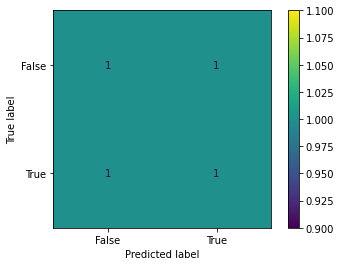

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = [0,1,1,0]
predicted = [1,0,1,0]

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [458]:
for i in range(5):
  for j in range(3):
    if j == 1:
      continue
    print(i,j,"Salam")

0 0 Salam
0 2 Salam
1 0 Salam
1 2 Salam
2 0 Salam
2 2 Salam
3 0 Salam
3 2 Salam
4 0 Salam
4 2 Salam
